In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# stop_words = stopwords.words('english')
import html
import unicodedata

import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

DATA VISUALIZATION

In [32]:
# load data
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/train.csv')


In [33]:
#sample text to visualize
train.dropna(inplace=True)
test.dropna(inplace=True)
print(test.shape)
print(train.shape)

(29934, 2)
(29934, 2)


Text(0.5, 0, 'Feature Labels')

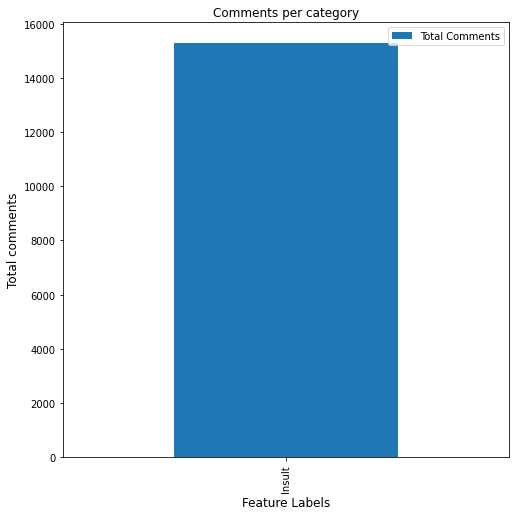

In [34]:
feature = train.drop(['Comment'], axis=1)  
counts = []                                             
categories = list(feature.columns.values)
for i in categories:
    counts.append((i, feature[i].sum()))
    
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments'])  
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

## Text preprocessing


In [35]:
import string

def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)



def remove_stopwords(words, stop_words):
    """Remove stopwords"""
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])


def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = text.lower()
    text = replace_numbers(text)
    words = word_tokenize(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train['Comment'] = train['Comment'].apply(lambda x: clean_text(x))
train.sample(1)['Comment'].values[0]


'yeah bunch whiney suck garbage problematic editor look spew gabemc post mine andreasesgdes talk page ben complain soon become apparent scale tip cocky editor favour admit complain apologie talk page harrassement childish looker buy political antic think meatpuppet even sockpuppet case arise nonsense future find way hard believe many editor feel like total idiot get catch three minute investigation act disgust come realize wp system complete utter embarrasing joke gabe agreement wont disclose detail protect plan begin work turn like rabid dog thank disagree edit watch inject nonapproved thethe change pink floyd article cocky test rape pilage another hundred music article thethe nonsense currently mediate dispute guy isnt interest further wp want name light wpownership guess ip do time go back account edit much fun bite bitch hasta luego joe'

In [36]:
test['Comment'] = test['Comment'].apply(lambda x: clean_text(x))
test.sample(1)["Comment"].values[0]

'racist western racist edit adverse reference western government organization action continue document publicly expose racism around net make cautionary example'

# Support Vector Machine

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


X = train["Comment"]
y = train['Insult']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0, stratify=y)

# Create a classifier in pipeline
insult_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(max_features=5000)),
                                 ('SVM',svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
                                 ])
insult_classifier.fit(X_train, y_train)


Pipeline(steps=[('pre_processing', TfidfVectorizer(max_features=5000)),
                ('SVM', SVC(gamma='auto', kernel='linear'))])

In [38]:
predictions_SVM = insult_classifier.predict(X_test)
print(f"SVM Accuracy Score -> {accuracy_score(predictions_SVM, y_test)*100}")

SVM Accuracy Score -> 89.0262234842158


In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions_SVM))

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      2929
         1.0       0.91      0.87      0.89      3058

    accuracy                           0.89      5987
   macro avg       0.89      0.89      0.89      5987
weighted avg       0.89      0.89      0.89      5987



# Deep Learning Models

## BoW 

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer  
tok = Tokenizer(num_words=1000, oov_token='UNK')
tok.fit_on_texts(train['Comment'] )
# Extract binary BoW features
x_train = tok.texts_to_sequences(train['Comment'])
x_test = tok.texts_to_sequences(test['Comment'])

vocab_size = len(tok.word_index) + 1
vocab_size


59080

## LSTM

In [41]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

maxlen = max([len(t) for t in x_train])
maxlen


1250

In [42]:
training_padded = pad_sequences(x_train,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )
test_padded = pad_sequences(x_test,
                            maxlen=50, 
                            truncating='post', 
                            padding='post'
                               )



In [43]:
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 128, input_length=50))
model.add(layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))




model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           7562240   
                                                                 
 lstm_1 (LSTM)               (None, 50, 512)           1312768   
                                                                 
 dense_1 (Dense)             (None, 50, 1)             513       
                                                                 
Total params: 8,875,521
Trainable params: 8,875,521
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(training_padded,
                     train[['Insult']],
                    epochs=1,
                    batch_size=512,
                   validation_split=0.2)


47/47 [==============================] - 135s 3s/step - loss: 0.6389 - accuracy: 0.6531 - val_loss: 0.8202 - val_accuracy: 0.4997


## Bidirectional

In [45]:
history.model.predict([test_padded],batch_size=1024, verbose=1)

30/30 [==============================] - 31s 1s/step


array([[[0.51337683],
        [0.5419569 ],
        [0.56891716],
        ...,
        [0.9276381 ],
        [0.92920184],
        [0.93064517]],

       [[0.51337683],
        [0.5419569 ],
        [0.56891716],
        ...,
        [0.9276381 ],
        [0.92920184],
        [0.93064517]],

       [[0.51337683],
        [0.5419569 ],
        [0.56891716],
        ...,
        [0.9276381 ],
        [0.92920184],
        [0.93064517]],

       ...,

       [[0.50245655],
        [0.500952  ],
        [0.49877712],
        ...,
        [0.8647434 ],
        [0.8706331 ],
        [0.8761745 ]],

       [[0.5237491 ],
        [0.5023137 ],
        [0.4864131 ],
        ...,
        [0.67394453],
        [0.68356586],
        [0.6933286 ]],

       [[0.5046361 ],
        [0.49866903],
        [0.5178848 ],
        ...,
        [0.8138269 ],
        [0.8221428 ],
        [0.83013546]]], dtype=float32)

In [46]:

# lstm_dim = 32
# model_bilstm = models.Sequential()
# model_bilstm.add(layers.Embedding(vocab_size, 512, input_length=50))
# model_bilstm.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
# model_bilstm.add(layers.Flatten())
# model_bilstm.add(layers.Dense(16, activation='relu'))
# model_bilstm.add(layers.Dense(1, activation='sigmoid'))


# model_bilstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# # Print the model summary
# model_bilstm.summary()

# history = model_bilstm.fit(training_padded,
#                      train[[ 'Insult']],
#                     epochs=2,
#                     batch_size=512,
#                    validation_split=0.2)

#Saving the Model

In [47]:
pickle.dump(insult_classifier, open("saved_model.pkl", "wb"))

In [48]:
#tweet_vectorized = tfidf_vectorizer.transform(["Hey my name is Christian. He said you are my bestie friend. Shall we"])
# Call the predict method on your vectorized tweets
tweet_pred = insult_classifier.predict(["Ama is telling the truth, gbemi"])
tweet_pred


array([0.])